<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install transformers --quiet
!pip install wget --quiet

In [26]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [27]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [28]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [29]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [30]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42) # .15 .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941 .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11529,)
(8646,)
(2883,)
(2883,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/5


100%|██████████| 4323/4323 [02:12<00:00, 32.73it/s]


Train loss 0.5584951362234325 accuracy 0.8224612537589637
Valid:
Accuracy: 86.26 %
Recall: 85.74 %
precision: 0.8436068531590057, recall: 0.8613699403322045, f1score: 0.8507128637676489
Test:
Accuracy: 88.1 %
Recall: 87.22 %
precision: 0.8604032586812851, recall: 0.878746269343536, f1score: 0.8681171259061481
*********************
              precision    recall  f1-score   support

           0     0.9348    0.8853    0.9094      1944
           1     0.7860    0.8722    0.8269       939

    accuracy                         0.8810      2883
   macro avg     0.8604    0.8787    0.8681      2883
weighted avg     0.8863    0.8810    0.8825      2883

Accuracy: 88.1 %
Recall: 87.22 %
Precision: 78.6 %
F1-score: 82.69 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1721
False Positives:  223
False Negatives:  120
True Positives:  819
Epoch 2/5


100%|██████████| 4323/4323 [01:43<00:00, 41.89it/s]


Train loss 0.44545396747240296 accuracy 0.8941707147814018
Valid:
Accuracy: 87.79 %
Recall: 81.85 %
precision: 0.8637368639120118, recall: 0.8633712304467022, f1score: 0.8635534908135355
Test:
Accuracy: 89.94 %
Recall: 83.81 %
precision: 0.8865902879386025, recall: 0.8835690056403582, f1score: 0.8850498698807479
*********************
              precision    recall  f1-score   support

           0     0.9224    0.9290    0.9257      1944
           1     0.8508    0.8381    0.8444       939

    accuracy                         0.8994      2883
   macro avg     0.8866    0.8836    0.8850      2883
weighted avg     0.8991    0.8994    0.8992      2883

Accuracy: 89.94 %
Recall: 83.81 %
Precision: 85.08 %
F1-score: 84.44 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1806
False Positives:  138
False Negatives:  152
True Positives:  787
Epoch 3/5


100%|██████████| 4323/4323 [01:43<00:00, 41.89it/s]


Train loss 0.3552521863075892 accuracy 0.9197316678232709
Valid:
Accuracy: 87.83 %
Recall: 84.62 %
precision: 0.8616590614932593, recall: 0.8704039671020802, f1score: 0.8656803072567302
Test:
Accuracy: 89.84 %
Recall: 86.37 %
precision: 0.881910745140853, recall: 0.8894041139115687, f1score: 0.8854566275213857
*********************
              precision    recall  f1-score   support

           0     0.9329    0.9151    0.9239      1944
           1     0.8309    0.8637    0.8470       939

    accuracy                         0.8984      2883
   macro avg     0.8819    0.8894    0.8855      2883
weighted avg     0.8997    0.8984    0.8989      2883

Accuracy: 89.84 %
Recall: 86.37 %
Precision: 83.09 %
F1-score: 84.7 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1779
False Positives:  165
False Negatives:  128
True Positives:  811
Epoch 4/5


100%|██████████| 4323/4323 [01:42<00:00, 42.21it/s]


Train loss 0.30136368514602846 accuracy 0.93499884339579
Valid:
Accuracy: 88.45 %
Recall: 87.38 %
precision: 0.8673572911140275, recall: 0.8818916303821964, f1score: 0.8736121099956518
Test:
Accuracy: 89.46 %
Recall: 87.54 %
precision: 0.876117345174116, recall: 0.8896029726922521, f1score: 0.882159832975326
*********************
              precision    recall  f1-score   support

           0     0.9376    0.9038    0.9204      1944
           1     0.8147    0.8754    0.8439       939

    accuracy                         0.8946      2883
   macro avg     0.8761    0.8896    0.8822      2883
weighted avg     0.8975    0.8946    0.8955      2883

Accuracy: 89.46 %
Recall: 87.54 %
Precision: 81.47 %
F1-score: 84.39 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1757
False Positives:  187
False Negatives:  117
True Positives:  822
Epoch 5/5


100%|██████████| 4323/4323 [01:42<00:00, 42.20it/s]


Train loss 0.24076248968184 accuracy 0.9479528105482304
Valid:
Accuracy: 88.55 %
Recall: 87.38 %
precision: 0.8685491836886834, recall: 0.882677793904209, f1score: 0.8746668373976799
Test:
Accuracy: 89.49 %
Recall: 87.01 %
precision: 0.8769578945689789, recall: 0.8884837757530338, f1score: 0.8822198009835275
*********************
              precision    recall  f1-score   support

           0     0.9353    0.9069    0.9209      1944
           1     0.8186    0.8701    0.8436       939

    accuracy                         0.8949      2883
   macro avg     0.8770    0.8885    0.8822      2883
weighted avg     0.8973    0.8949    0.8957      2883

Accuracy: 89.49 %
Recall: 87.01 %
Precision: 81.86 %
F1-score: 84.36 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1763
False Positives:  181
False Negatives:  122
True Positives:  817
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

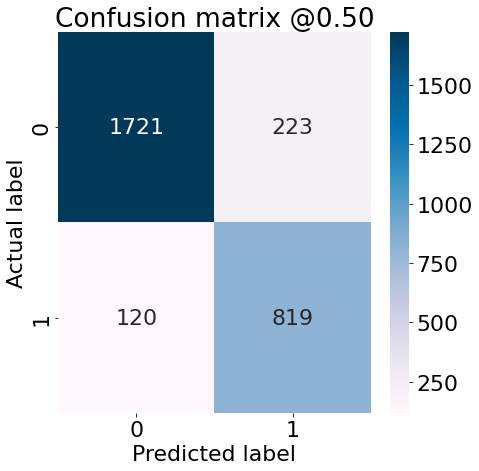

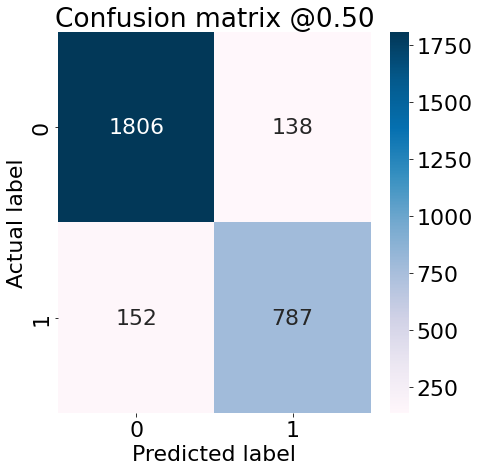

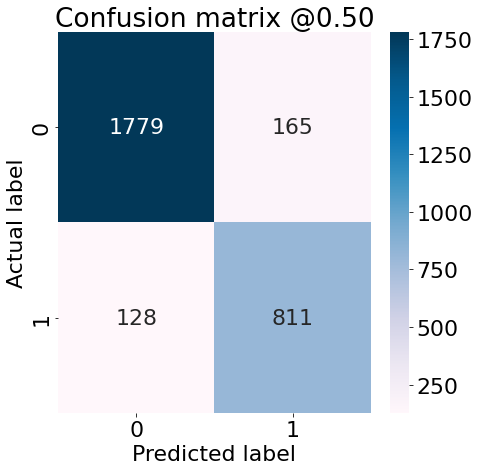

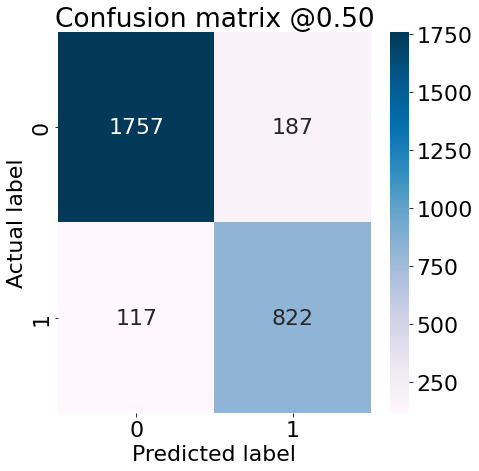

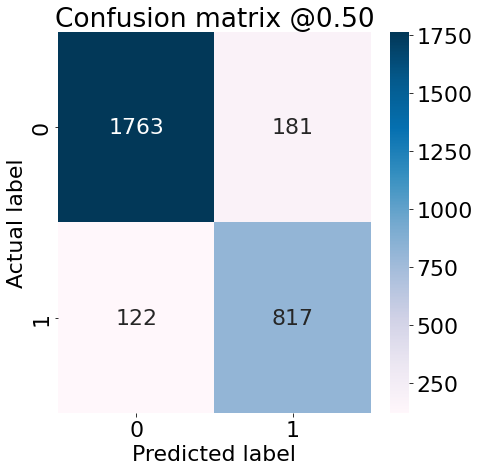

In [31]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=5
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)